<a href="https://colab.research.google.com/github/shizukuyu/machine-learning/blob/master/germany_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings



## Data selection

I download all the germany stations data from 2023-01 to 2023-06 to select the suitable weather stations to do further prediction.

In [42]:
pp = pd.read_csv('ge-all-2.csv')
df = pp.drop(columns=['NAME','ELEVATION','SNWD'])
df['DATE'] = pd.to_datetime(df['DATE'])
df['year_month'] = df['DATE'].dt.to_period('M')

monthly_avg_prcp = df.groupby(['STATION', 'LATITUDE', 'LONGITUDE','year_month'])['PRCP'].mean().reset_index()
monthly_avg_prcp.columns = ['STATION', 'LATITUDE', 'LONGITUDE','year_month', 'avg_PRCP']
monthly_avg_prcp['year_month'] = monthly_avg_prcp['year_month'].dt.strftime('%Y-%m')
monthly_avg_prcp['precip']= monthly_avg_prcp['avg_PRCP']*25.4

monthly_avg_prcp

,STATION,LATITUDE,LONGITUDE,year_month,avg_PRCP,precip
0,GM000001474,53.1017,8.7842,2023-01,0.089355,2.269613
1,GM000001474,53.1017,8.7842,2023-02,0.050357,1.279071
2,GM000001474,53.1017,8.7842,2023-03,0.109032,2.769419
3,GM000001474,53.1017,8.7842,2023-04,0.057000,1.447800
4,GM000001474,53.1017,8.7842,2023-05,0.033871,0.860323
...,...,...,...,...,...,...
3278,NLE00109280,50.9831,5.9831,2023-02,0.019286,0.489857
3279,NLE00109280,50.9831,5.9831,2023-03,0.138065,3.506839
3280,NLE00109280,50.9831,5.9831,2023-04,0.067000,1.701800
3281,NLE00109280,50.9831,5.9831,2023-05,0.057419,1.458452


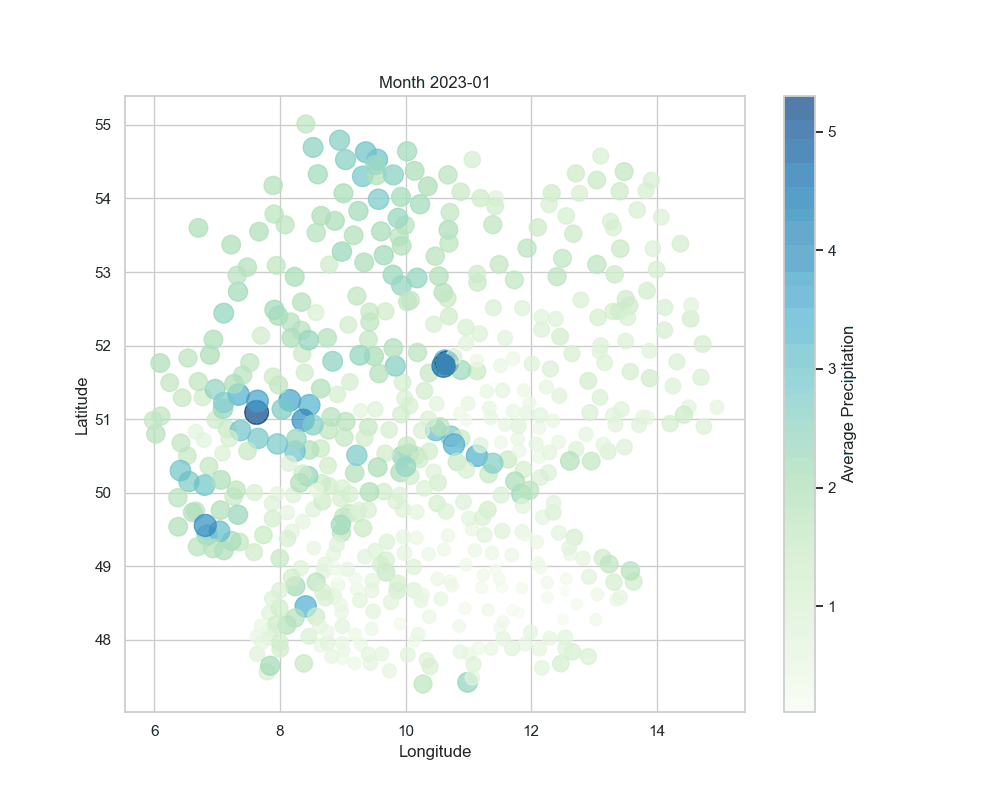

In [43]:
from IPython.display import Image
gif_path = 'monthly_precip_scatter_overlay.gif'
Image(filename=gif_path)

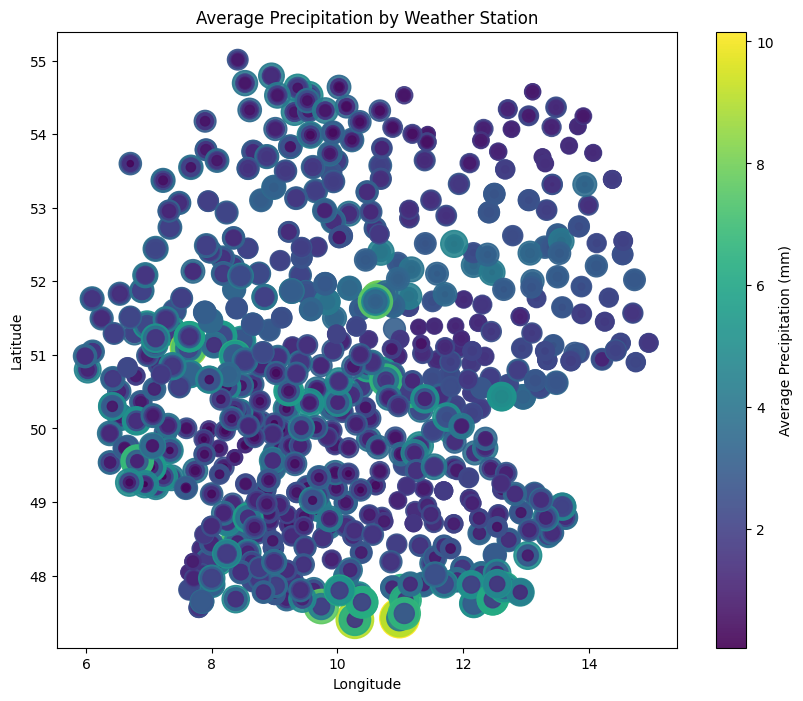

In [44]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(monthly_avg_prcp['LONGITUDE'], monthly_avg_prcp['LATITUDE'],
                      s=monthly_avg_prcp['precip'] * 80, alpha=0.9,
                      c=monthly_avg_prcp['precip'], cmap="viridis")


cbar = plt.colorbar(scatter)
cbar.set_label('Average Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Precipitation by Weather Station')
plt.show()


from the plot above, latitude: 53-54.5, longitude:8-10, the precipitation conditions are more similar so I choose some of the stations within this area.

Actually it is a simple way to caputure the space similarity between the weather stations.

There are also other ways to do extraction of spatial characteristics of precipitation, such as traditional convolutional neural networks. But the weather points are not evenly distributed, that is, the distances between the points are not the same, so CNN may not suitable for processing irregularly distributed data.

If there are moretime, graph convolutional neural networks (GCNs), especially spatial convolution, can be used to directly extract the spatial features of these data

In [45]:
filtered_df = monthly_avg_prcp[(monthly_avg_prcp['LATITUDE'] >= 53) & (monthly_avg_prcp['LATITUDE'] <= 54.5) &
                 (monthly_avg_prcp['LONGITUDE'] >= 8) & (monthly_avg_prcp['LONGITUDE'] <= 10)]

sorted_df = filtered_df[['STATION', 'precip']].sort_values(by='precip', ascending=False)
sorted_df[:15]

,STATION,precip
508,GME00121846,4.563806
1036,GME00124222,4.498258
2518,GME00131050,4.219677
1767,GME00127534,3.826387
1042,GME00124234,3.801806
2140,GME00129214,3.711677
2100,GME00129046,3.670710
1150,GME00124690,3.605161
2538,GME00131122,3.572387
682,GME00122482,3.564194


### Data cleaning & fill null values

In [46]:
one = pd.read_csv('10-stat-3.csv',index_col='DATE')

In [47]:
one['precip']= one['PRCP']*25.4
df1 = one[['STATION', 'SNWD', 'TMAX', 'TMIN', 'precip']].copy()
df1.columns = ['station', 'snow_depth', 'temp_max', 'temp_min', 'precip']
df1['snow_depth'].fillna(method='ffill', inplace=True)

In [48]:
df1

,station,snow_depth,temp_max,temp_min,precip
DATE,,,,,
2016-01-01,GM000010147,0.0,43.0,32.0,0.000
2016-01-02,GM000010147,0.0,40.0,22.0,0.000
2016-01-03,GM000010147,0.0,23.0,19.0,0.000
2016-01-04,GM000010147,0.0,20.0,17.0,0.000
2016-01-05,GM000010147,0.0,25.0,19.0,0.508
...,...,...,...,...,...
2023-12-27,GMM00010129,0.0,47.0,35.0,1.016
2023-12-28,GMM00010129,0.0,51.0,46.0,4.572
2023-12-29,GMM00010129,0.0,50.0,44.0,1.778


in the previous section i mentioned i choose weather station data from close area, so at this stage i just calculate the average values of each features within one day across different weather stations.

But if more specific research standard required, its possible to train a machine learning model that predicts future rainfall at multiple weather stations.

- Multi-output Neural Networks:

Multi-output Neural Networks can be used to predict multiple output variables simultaneously by designing appropriate output layers. For example, set multiple nodes in the output layer of a neural network, each node corresponding to the rainfall forecast for a weather station.

- Sequence-to-Sequence Models:

Extending sequence-to-sequence models (such as Seq2Seq models based on attention mechanisms) to multi-output tasks can be used to predict time series data from multiple weather stations, such as predicting future rainfall for multiple weather stations at the same time.

In [49]:
numeric_columns = ['snow_depth', 'temp_max', 'temp_min', 'precip']
daymean = df1.groupby(df1.index)[numeric_columns].mean()

daymean

,snow_depth,temp_max,temp_min,precip
DATE,,,,
2016-01-01,0.000000,43.411765,34.235294,0.048381
2016-01-02,0.000000,39.941176,23.882353,0.024190
2016-01-03,0.019048,24.294118,20.705882,0.895048
2016-01-04,0.433333,22.117647,18.823529,0.108857
2016-01-05,0.266667,25.294118,20.117647,1.294190
...,...,...,...,...
2023-12-27,0.000000,46.117647,33.529412,2.056190
2023-12-28,0.000000,51.882353,45.176471,5.297714
2023-12-29,0.000000,49.823529,43.176471,4.632476


In [50]:
daymean.index = pd.to_datetime(daymean.index)

In [51]:
daymean['month'] = daymean.index.month
daymean['day'] = daymean.index.day
daymean['heavy_precip'] = np.where(daymean['precip'] > 10, 1, 0)
daymean['heavy_precip'].value_counts()
daymean['year'] = daymean.index.year
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

daymean['season'] = daymean['month'].apply(get_season)

In [52]:
precip_counts = daymean['precip'].value_counts().sort_index(ascending=False)
print(precip_counts)

precip
30.911800      1
26.270857      1
25.552400      1
23.501048      1
23.234952      1
            ... 
0.014111       1
0.013368       3
0.012700      15
0.012095      51
0.000000     807
Name: count, Length: 1037, dtype: int64


<ipython-input-53-1bf3f1d1eae5>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='day', y='precip', data=daymean, ci=None, ax=axes[0, 0])
<ipython-input-53-1bf3f1d1eae5>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='month', y='precip', data=daymean, ci=None, ax=axes[0, 1])
<ipython-input-53-1bf3f1d1eae5>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='season', y='precip', data=daymean, ci=None, ax=axes[1, 0])
<ipython-input-53-1bf3f1d1eae5>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='year', y='precip', data=daymean, ci=None, ax=axes[1, 1])


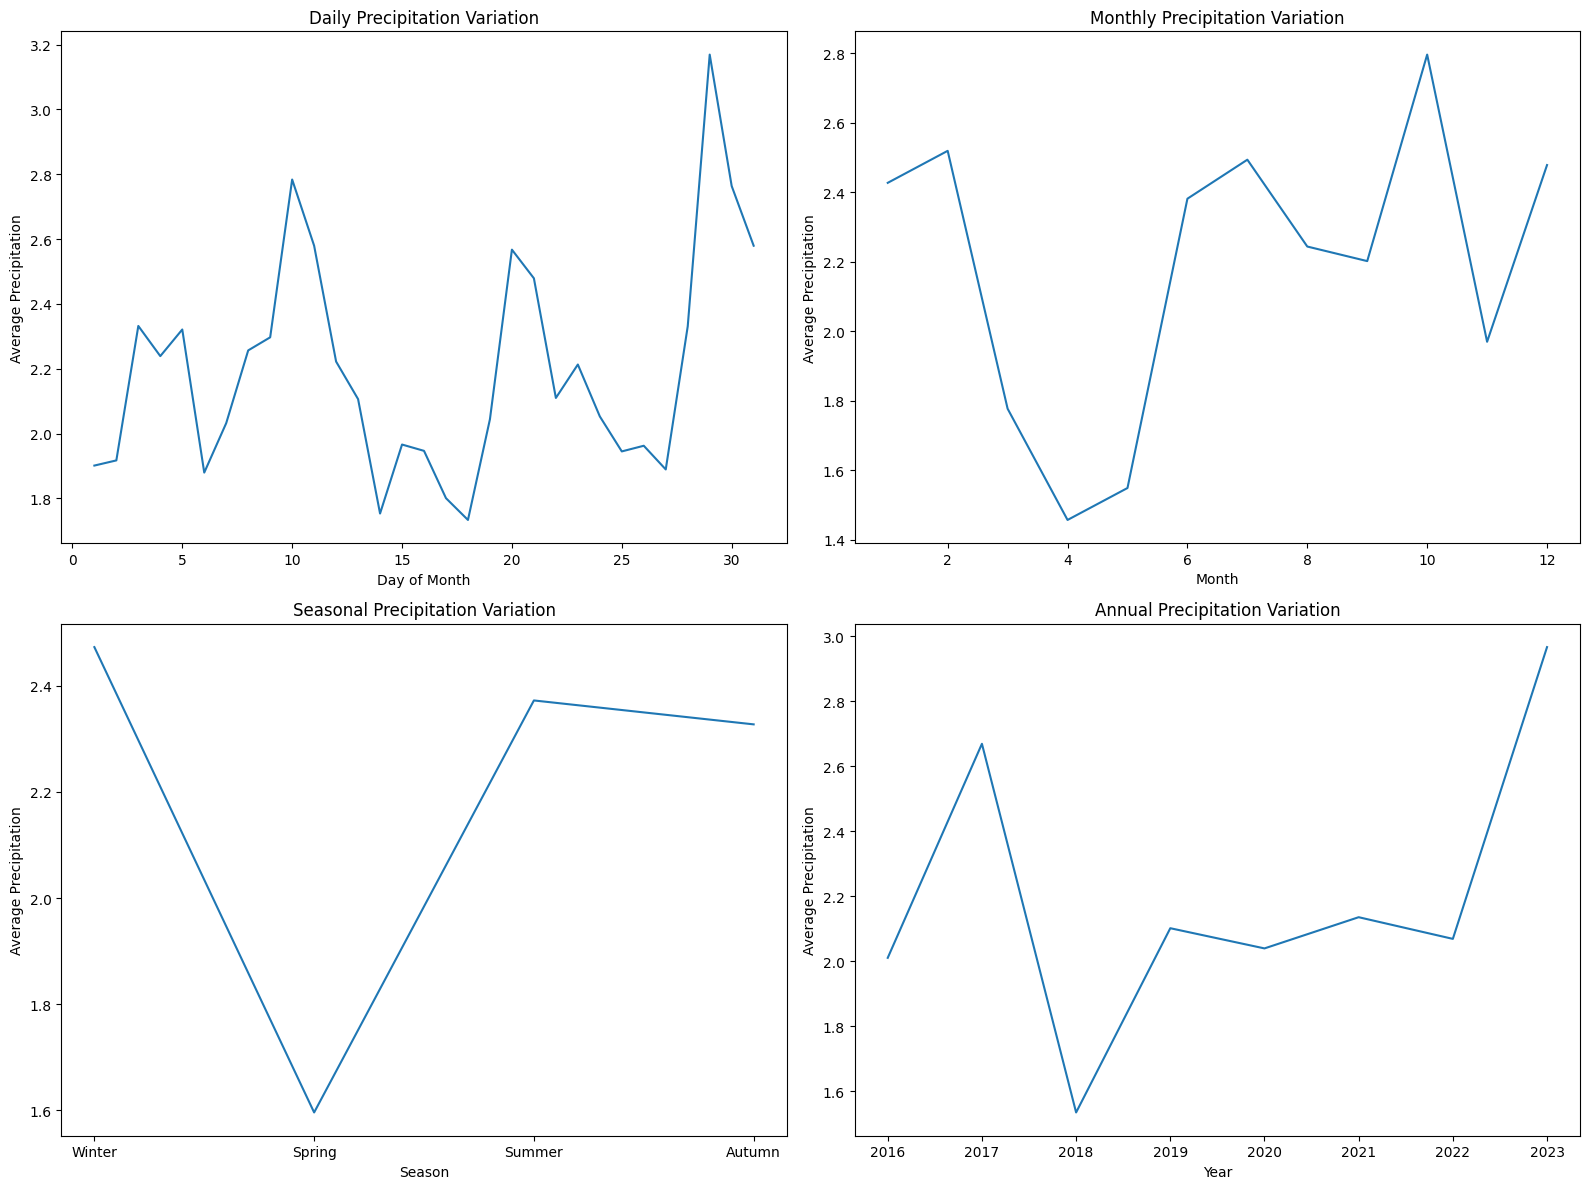

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Daily variation
sns.lineplot(x='day', y='precip', data=daymean, ci=None, ax=axes[0, 0])
axes[0, 0].set_title('Daily Precipitation Variation')
axes[0, 0].set_xlabel('Day of Month')
axes[0, 0].set_ylabel('Average Precipitation')

# Monthly variation
sns.lineplot(x='month', y='precip', data=daymean, ci=None, ax=axes[0, 1])
axes[0, 1].set_title('Monthly Precipitation Variation')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Precipitation')

# Seasonal variation
sns.lineplot(x='season', y='precip', data=daymean, ci=None, ax=axes[1, 0])
axes[1, 0].set_title('Seasonal Precipitation Variation')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Precipitation')

# Annual variation
sns.lineplot(x='year', y='precip', data=daymean, ci=None, ax=axes[1, 1])
axes[1, 1].set_title('Annual Precipitation Variation')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Precipitation')

plt.tight_layout()
plt.show()


feature engineering for the future classification and regression problem
- rolling_precip_7: 7-day rolling average precipitation
- rolling_temp_max_7: 7-day rolling average of maximum temperature
- rolling_temp_min_7: 7-day rolling average of minimum temperature

In [54]:
daymean['rolling_precip_7'] = daymean['precip'].rolling(window=7).mean()
daymean['rolling_temp_max_7'] = daymean['temp_max'].rolling(window=7).mean()
daymean['rolling_temp_min_7'] = daymean['temp_min'].rolling(window=7).mean()
daymean['temp_range'] = daymean['temp_max'] - daymean['temp_min']

In [55]:
daymean = daymean.iloc[6:]
daymean.apply(pd.isnull).sum()

snow_depth            0
temp_max              0
temp_min              0
precip                0
month                 0
day                   0
heavy_precip          0
year                  0
season                0
rolling_precip_7      0
rolling_temp_max_7    0
rolling_temp_min_7    0
temp_range            0
dtype: int64

In [56]:
daymean.dtypes

snow_depth            float64
temp_max              float64
temp_min              float64
precip                float64
month                   int32
day                     int32
heavy_precip            int64
year                    int32
season                 object
rolling_precip_7      float64
rolling_temp_max_7    float64
rolling_temp_min_7    float64
temp_range            float64
dtype: object

In [57]:
numeric_columns = daymean.select_dtypes(include=['float64', 'int32', 'int64']).columns
correlation_matrix = daymean[numeric_columns].corr()
correlation_matrix

,snow_depth,temp_max,temp_min,precip,month,day,heavy_precip,year,rolling_precip_7,rolling_temp_max_7,rolling_temp_min_7,temp_range
snow_depth,1.000000,-0.253364,-0.278705,-0.028736,-0.011478,-0.043896,-0.025695,0.050676,-0.052020,-0.259267,-0.285626,-0.093205
temp_max,-0.253364,1.000000,0.882171,-0.007805,0.178569,0.036023,-0.003298,0.024336,-0.065459,0.926806,0.849241,0.698776
temp_min,-0.278705,0.882171,1.000000,0.137530,0.281786,0.043999,0.057375,0.012929,0.085688,0.867489,0.893151,0.279566
precip,-0.028736,-0.007805,0.137530,1.000000,0.029259,0.019271,0.751969,0.040315,0.466735,0.004836,0.074694,-0.224820
month,-0.011478,0.178569,0.281786,0.029259,1.000000,0.005971,0.000454,-0.004467,0.049392,0.217924,0.324988,-0.063968
day,-0.043896,0.036023,0.043999,0.019271,0.005971,1.000000,0.009802,-0.005064,-0.025698,0.036752,0.045267,0.006609
heavy_precip,-0.025695,-0.003298,0.057375,0.751969,0.000454,0.009802,1.000000,0.033740,0.291646,-0.003325,0.031907,-0.093878
year,0.050676,0.024336,0.012929,0.040315,-0.004467,-0.005064,0.033740,1.000000,0.077091,0.027510,0.016052,0.029976
rolling_precip_7,-0.052020,-0.065459,0.085688,0.466735,0.049392,-0.025698,0.291646,0.077091,1.000000,-0.028249,0.139328,-0.263617
rolling_temp_max_7,-0.259267,0.926806,0.867489,0.004836,0.217924,0.036752,-0.003325,0.027510,-0.028249,1.000000,0.938684,0.571851


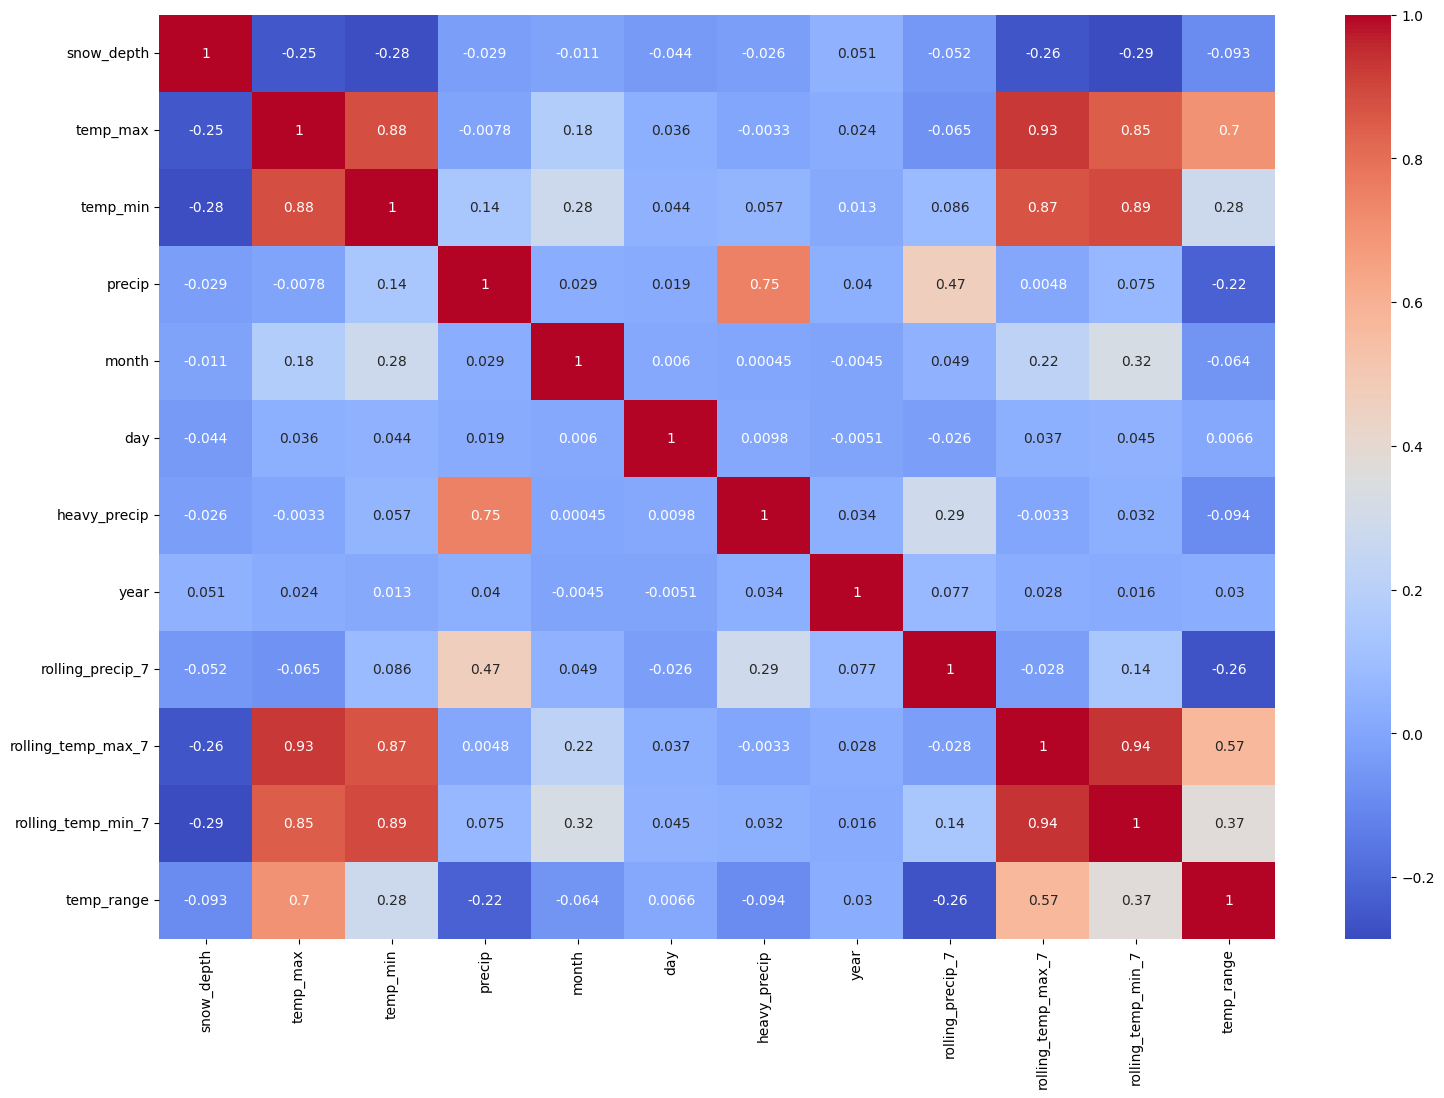

In [58]:
plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix, yticklabels='auto', annot=True, cmap='coolwarm')
plt.show()

### Machine Learning

'heavy_precip' is derived from precip and the goal is to predict 'heavy_precip', so I do not include precip as a feature

Continuous Features:

- snow_depth: Snow depth
- temp_max: Maximum temperature
- temp_min: Minimum temperature
- rolling_precip_7: 7-day rolling average precipitation
- rolling_temp_max_7: 7-day rolling average of maximum temperature
- rolling_temp_min_7: 7-day rolling average of minimum temperature
- temp_range: Temperature range (temp_max - temp_min)

Categorical Features:

- month: Month
- day: Day
- year: Year
- season_Autumn, season_Spring, season_Summer, season_Winter: One-hot encoded seasons

In [59]:
season_dummies = pd.get_dummies(daymean['season'], prefix='season')
daymean = pd.concat([daymean.drop(columns=['season']), season_dummies], axis=1)

In [60]:
features = [
    'temp_max', 'temp_min', 'snow_depth',
    'month', 'day', 'rolling_precip_7', 'rolling_temp_max_7',
    'rolling_temp_min_7', 'temp_range','season_Autumn','season_Spring','season_Summer','season_Winter',
]
train = daymean.loc[:"2021-12-31"]
test = daymean.loc["2022-01-01":]

### Classification model

#### Radom Forest

In [61]:
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier()
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(class_weight='balanced')

knn.fit(train[features], train['heavy_precip'])
tree.fit(train[features], train['heavy_precip'])
lr.fit(train[features], train['heavy_precip'])
rf.fit(train[features], train['heavy_precip'])

y_pred_knn = knn.predict(test[features])
y_pred_tree = tree.predict(test[features])
y_pred_lr = lr.predict(test[features])
y_pred_rf = rf.predict(test[features])

In [62]:
cm_knn = confusion_matrix(test['heavy_precip'], y_pred_knn)
cm_tree = confusion_matrix(test['heavy_precip'], y_pred_tree)
cm_lr = confusion_matrix(test['heavy_precip'], y_pred_lr)
cm_rf = confusion_matrix(test['heavy_precip'], y_pred_rf)

accuracy_knn = accuracy_score(test['heavy_precip'], y_pred_knn)
accuracy_tree = accuracy_score(test['heavy_precip'], y_pred_tree)
accuracy_lr = accuracy_score(test['heavy_precip'], y_pred_lr)
accuracy_rf = accuracy_score(test['heavy_precip'], y_pred_rf)

report_knn = classification_report(test['heavy_precip'], y_pred_knn)
report_tree = classification_report(test['heavy_precip'], y_pred_tree)
report_lr = classification_report(test['heavy_precip'], y_pred_lr)
report_rf = classification_report(test['heavy_precip'], y_pred_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(report_knn)
print(report_tree)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       683
           1       0.00      0.00      0.00        47

    accuracy                           0.93       730
   macro avg       0.47      0.50      0.48       730
weighted avg       0.88      0.93      0.90       730

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       683
           1       0.20      0.19      0.20        47

    accuracy                           0.90       730
   macro avg       0.57      0.57      0.57       730
weighted avg       0.90      0.90      0.90       730



In [64]:
print(report_lr)
print(report_rf)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       683
           1       0.33      0.06      0.11        47

    accuracy                           0.93       730
   macro avg       0.64      0.53      0.54       730
weighted avg       0.90      0.93      0.91       730

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       683
           1       0.00      0.00      0.00        47

    accuracy                           0.94       730
   macro avg       0.47      0.50      0.48       730
weighted avg       0.88      0.94      0.90       730



In [65]:
print("confusion matrix of Decision Tree:")
print(cm_tree)

confusion matrix of Decision Tree:
[[647  36]
 [ 38   9]]


In [66]:
print("confusion matrix of Logistic Regression:")
print(cm_lr)

confusion matrix of Logistic Regression:
[[677   6]
 [ 44   3]]


#### Unbalanced samples
These models performs good at the marjority class heavy_precip = 0, because of the unbalanced samples, they do not have better performance on the minority.

I try three ways to deal with the sample unbalance problem
- adjust(lower) the threshold to control the classification preference
- Search for the best para for random forest
- adjust the weight
- oversampling: SMOTE（Synthetic Minority Over-sampling Technique）
- try different models

##### - Adjust threshold & check ROC Curve

In [67]:
pred_prob = tree.predict_proba(test[features])[:, 1]
pred_ad = (pred_prob >= 0.3).astype(int)
print('Accuracy:', accuracy_score(test['heavy_precip'], pred_ad))
print(classification_report(test['heavy_precip'], pred_ad))

Accuracy: 0.8986301369863013
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       683
           1       0.20      0.19      0.20        47

    accuracy                           0.90       730
   macro avg       0.57      0.57      0.57       730
weighted avg       0.90      0.90      0.90       730



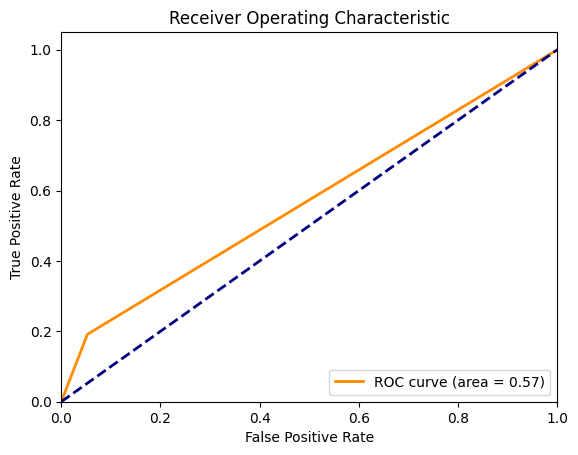

In [68]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

fpr, tpr, thresholds = roc_curve(test['heavy_precip'], pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##### - GridSearchCV for random forest

In [69]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(train[features], train['heavy_precip'])

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(train[features], train['heavy_precip'])
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(test[features])

report = classification_report(test['heavy_precip'], y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       683
           1       0.18      0.23      0.20        47

    accuracy                           0.88       730
   macro avg       0.56      0.58      0.57       730
weighted avg       0.90      0.88      0.89       730



In [70]:
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'max_depth': 10, 'n_estimators': 100}


##### - Change the weight of 0 and 1 and retrain the model

In [71]:
class_weights = {0: 1.0, 1: len(train['heavy_precip'][train['heavy_precip'] == 0]) / len(train['heavy_precip'][train['heavy_precip'] == 1])}

In [72]:
model = RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42)
model.fit(train[features], train['heavy_precip'])
pred = model.predict(test[features])
report = classification_report(test['heavy_precip'], pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       683
           1       0.00      0.00      0.00        47

    accuracy                           0.94       730
   macro avg       0.47      0.50      0.48       730
weighted avg       0.88      0.94      0.90       730



unfortunatly the result even is not good as without the weight setting

##### - try different models
- Support Vector Machine
- GradientBoostingClassifier
- XGBoost

Support Vector Machine

In [73]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(train[features], train['heavy_precip'])


svm_predictions = svm_model.predict(test[features])
print("SVM Classification Report:")
print(classification_report(test['heavy_precip'], svm_predictions, zero_division=0))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       683
           1       0.00      0.00      0.00        47

    accuracy                           0.94       730
   macro avg       0.47      0.50      0.48       730
weighted avg       0.88      0.94      0.90       730



Gradiant Boost

In [74]:
from sklearn.ensemble import GradientBoostingClassifier


gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(train[features], train['heavy_precip'])

gb_predictions = gb_model.predict(test[features])
print("Gradient Boosting Classification Report:")
print(classification_report(test['heavy_precip'], gb_predictions))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       683
           1       0.17      0.02      0.04        47

    accuracy                           0.93       730
   macro avg       0.55      0.51      0.50       730
weighted avg       0.89      0.93      0.90       730



XGBoost

In [75]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(train[features], train['heavy_precip'])

xgb_predictions = xgb_model.predict(test[features])
print("XGBoost Classification Report:")
print(classification_report(test['heavy_precip'], xgb_predictions))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       683
           1       0.24      0.13      0.17        47

    accuracy                           0.92       730
   macro avg       0.59      0.55      0.56       730
weighted avg       0.90      0.92      0.91       730



##### - oversampling

In [76]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(train[features], train['heavy_precip'])
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train_resampled, y_train_resampled)

xgb_predictions = xgb_model.predict(test[features])
print("XGBoost Classification Report:")
print(classification_report(test['heavy_precip'], xgb_predictions))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       683
           1       0.19      0.30      0.23        47

    accuracy                           0.87       730
   macro avg       0.57      0.61      0.58       730
weighted avg       0.90      0.87      0.89       730



The detection of precipitation events over 10mm/day can be seen as different anomaly events.

So if possible some anomaly detection algorithms such as Isolated Forest, LOF, One-Class SVM, etc. can be used to identify abnormal heavy rain events. They are effective at identifying events in the data that differ significantly from normal patterns and may represent extreme climate conditions.

### Regression Model

#### linear model for regression of precipitation amount

- Ridge

In [77]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

features2 =['temp_max', 'temp_min', 'snow_depth', 'year',
    'month', 'day', 'season_Autumn','season_Spring','season_Summer','season_Winter',
    'rolling_precip_7', 'rolling_temp_max_7','rolling_temp_min_7', 'temp_range']

In [78]:
red = Ridge(alpha=.1)
red.fit(train[features2], train["precip"])
predictions = red.predict(test[features2])
mean_squared_error(test["precip"], predictions)

9.98975626641397

In [79]:
combined = pd.concat([test["precip"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

<Axes: xlabel='DATE'>

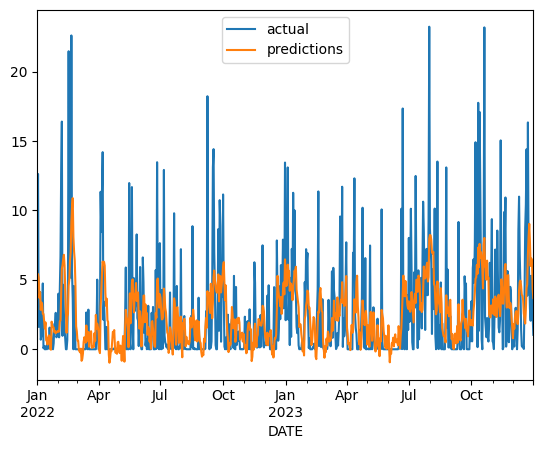

In [80]:
combined.plot()

In [81]:
daymean.corr()["precip"]

snow_depth           -0.028736
temp_max             -0.007805
temp_min              0.137530
precip                1.000000
month                 0.029259
day                   0.019271
heavy_precip          0.751969
year                  0.040315
rolling_precip_7      0.466735
rolling_temp_max_7    0.004836
rolling_temp_min_7    0.074694
temp_range           -0.224820
season_Autumn         0.021676
season_Spring        -0.098055
season_Summer         0.029223
season_Winter         0.047672
Name: precip, dtype: float64

In [82]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()
combined.sort_values("diff", ascending=False).head(10)

,actual,predictions,diff
DATE,,,
2022-02-16,21.469048,4.577626,16.891422
2023-07-31,23.234952,7.963013,15.271940
2023-10-20,23.186571,8.018836,15.167735
2022-09-08,18.227524,4.183335,14.044189
2022-02-20,22.606000,9.147291,13.458709
2023-06-22,17.344571,4.021458,13.323114
2023-11-13,15.046476,3.082123,11.964353
2022-02-06,16.401143,5.791392,10.609751
2023-10-11,17.754600,7.323588,10.431012


In [89]:
filtered = combined[combined["actual"] > 10]
result = filtered[["actual", "predictions", "diff"]]
result.sort_values("diff", ascending=False).head(10)


,actual,predictions,diff
DATE,,,
2022-02-16,21.469048,4.577626,16.891422
2023-07-31,23.234952,7.963013,15.271940
2023-10-20,23.186571,8.018836,15.167735
2022-09-08,18.227524,4.183335,14.044189
2022-02-20,22.606000,9.147291,13.458709
2023-06-22,17.344571,4.021458,13.323114
2023-11-13,15.046476,3.082123,11.964353
2022-02-06,16.401143,5.791392,10.609751
2023-10-11,17.754600,7.323588,10.431012


<Axes: xlabel='DATE'>

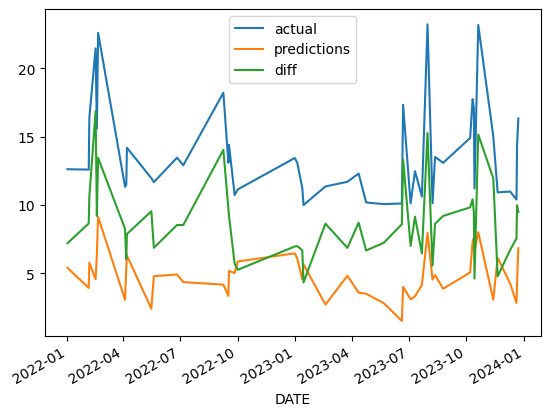

In [90]:
result.plot()

### Time Series Prediction

#### LSTM

<Axes: xlabel='DATE'>

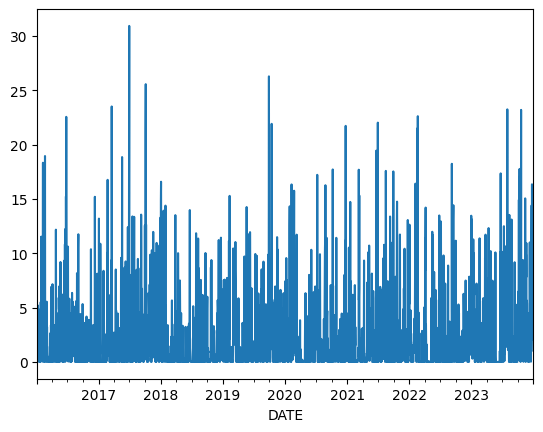

In [91]:
precip = daymean['precip']
precip.plot()

In [92]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)


WINDOW_SIZE = 7
X1, y1 = df_to_X_y(precip, WINDOW_SIZE)
X1.shape, y1.shape
X_train1, y_train1 = X1[:2100], y1[:2100]
X_val1, y_val1 = X1[2100:2200], y1[2100:2200]
X_test1, y_test1 = X1[2200:], y1[2200:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((2100, 7, 1), (2100,), (100, 7, 1), (100,), (709, 7, 1), (709,))

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100],label='Predict')
plt.plot(train_results['Actuals'][50:100],label='Actual')
plt.legend()

test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results
plt.plot(test_results['Test Predictions'][:100],label='Predict')
plt.plot(test_results['Actuals'][:100],label='Actual')
plt.legend()
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)
plot_predictions1(model1, X_test1, y_test1)
model2 = Sequential()
model2.add(InputLayer((7, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])
model3 = Sequential()
model3.add(InputLayer((7, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])
plot_predictions1(model3, X_test1, y_test1)
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][3]
    y.append(label)
  return np.array(X), np.array(y)
X2, y2 = df_to_X_y2(df)
X2.shape, y2.shape
X2_train, y2_train = X2[:2100], y2[:2100]
X2_val, y2_val = X2[2100:2200], y2[2100:2200]
X2_test, y2_test = X2[2200:], y2[2200:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape
precip_training_mean = np.mean(X2_train[:, :, 3])
precip_training_std = np.std(X2_train[:, :, 3])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - precip_training_mean) / precip_training_std
  return X
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
model4 = Sequential()
model4.add(InputLayer((7, 4)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])
plot_predictions1(model4, X2_test, y2_test)